## Convolutional & Conditional VAEs

In this problem you will implement: 
1. a **convolutional** variational autoencoder
2. a (convolutional) **conditional** variational autoencoder,

trained on the MNIST dataset. 
The convolutional parameterization will help you achieve better marginal log likelihood. Using the conditional VAE, you'll be able to generate novel images of a specified class.


In [1]:
%pylab inline
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.distributions import MultivariateNormal

Populating the interactive namespace from numpy and matplotlib


In [2]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True, 
          transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)




---
# 1. Convolutional variational autoencoder (20 points)


Your task is to implement a VAE for MNIST, using a **convolutional network** in the encoder, and a **convolutional network** in the decoder.

- **Overall Goal:** achieve better estimated marginal likelihood than in the lab
  - Keep `z=20` as in the lab 


**Encoder**: you are free to design the convolutional network how you want. 
  - We used three `Conv2d + ReLU` layers, with an output size of `B x 64 x 7 x 7`.
  - Hint: Flatten the output of your convolutional network before mapping it to the encoder outputs, e.g. $\mu = \texttt{linear(flatten(conv(x)))}$


**Decoder**: you are free to design the convolutional network how you want. 
  - We used three `ConvTranspose2d + ReLU` layers, with an input size of `B x 64 x 7 x 7`.
  - Hint: Map the $\mathbf{z}$ input to the convolutional input size.
    - $\hat{x}=\texttt{deconv(reshape(linear(z)))}$

In [9]:
class Encoder(nn.Module):
  def __init__(self, zdim):
    super().__init__()
    # TODO
    self.convolution_1 = nn.Conv2d(in_channels= 1, out_channels= 8, kernel_size= 3, stride= 1, padding=0)
    self.activation_1 = nn.ReLU()

    self.convolution_2 = nn.Conv2d(in_channels= 8, out_channels= 16, kernel_size= 3, stride= 2, padding=0)
    self.activation_2 = nn.ReLU()

    self.convolution_3 = nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size= 3, stride= 1, padding= 0)
    self.activation_3 = nn.ReLU()

    self.flat = nn.Flatten()

    self.mu = nn.Linear(in_features= 3200, out_features= zdim)
    self.logvar = nn.Linear(in_features= 3200, out_features= zdim)
    
    self.zdim = zdim

  def forward(self, x):
    # TODO
    #Shape : (,1,28,28)
    x = self.convolution_1(x)
    x = self.activation_1(x)

    #Shape : (,8, 26, 26)
    x = self.convolution_2(x)
    x = self.activation_2(x)

    #Shape : (, 16, 12, 12)

    x = self.convolution_3(x)
    x = self.activation_3(x)

    #Shape : (,32, 10, 10)

    h = self.flat(x)

    
    mu = self.mu(h)
    logvar = self.logvar(h)

    return mu, logvar

class Decoder(nn.Module):
  def __init__(self, zdim):
    super().__init__()
    self.linear = nn.Linear(in_features= zdim, out_features= 3200)

    self.transpose_1 = nn.ConvTranspose2d(in_channels= 32, out_channels= 16, kernel_size= 3, output_padding= 1, stride= 2, padding= 4)
    self.activation_1 = nn.ReLU()

    self.transpose_2 = nn.ConvTranspose2d(in_channels= 16, out_channels= 8, kernel_size= 3, output_padding= 1, stride= 2, padding= 5)
    self.activation_2 = nn.ReLU()

    self.transpose_3 = nn.ConvTranspose2d(in_channels= 8, out_channels= 4, kernel_size= 3, output_padding= 1, stride= 2, padding= 9)
    self.activation_3 = nn.ReLU()

    self.transpose_4 = nn.ConvTranspose2d(in_channels= 4, out_channels= 1, kernel_size= 3, output_padding= 1, stride=2, padding= 11)
    self.activation_4 = nn.Sigmoid()
    
    self.zdim = zdim
    
  def forward(self, x):
    # Shape : (, zdim)
      x = self.linear(x)

      # Shape : (, 3200)
      x = x.reshape([ -1 , 32, 10, 10])
      
      # Shape : (, 32, 10, 10)
      x = self.transpose_1(x)
      x = self.activation_1(x)

      # Shape : (, 16, 14, 14)
      x = self.transpose_2(x)
      x = self.activation_2(x)

      # Shape : (, 8, 20, 20)
      x = self.transpose_3(x)
      x = self.activation_3(x)

      # Shape : (, 4, 24, 24)
      x = self.transpose_4(x)
      xhat = self.activation_4(x)
      
      
      return xhat
  
class VAE(nn.Module):
  def __init__(self, xdim, hdim, zdim):
    super().__init__()
    self.encoder = Encoder(zdim)
    self.decoder = Decoder(zdim)
    self.hdim = hdim
    self.zdim = zdim

  def reparameterize(self, mu, logvar):
    if self.training:
      std = torch.exp(0.5*logvar)
      epsln = torch.randn_like(std)
      z = mu + std*epsln
    else:
      z = mu
    return z
    
  
  def forward(self, x):
    mu, logvar = self.encoder(x)
    z = self.reparameterize(mu, logvar)
    xhat = self.decoder(z)
    return xhat, mu, logvar



**Loss**: does anything change from the lab?

In [ ]:
# hint: see lab

In [10]:
def loss_function(xhat, x, mu, logvar, kl_weight=1.0):
  BCE = nn.functional.binary_cross_entropy(
      xhat.view(xhat.size(0), -1), x.view(x.size(0), -1), reduction='none'
  ).sum(1).mean()
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1).mean()

  loss = BCE + kl_weight*KLD
  return loss, BCE.item(), KLD.item()

**Train on MNIST**: does anything change from the lab?

**Your task:** Implement training logic, and *produce a plot of training loss and a plot of validation loss* (x-axis: epoch, y-axis: loss). Each plot should contain three lines: total loss, BCE, and KL-divergence.

In [11]:
device = torch.device("cuda:0")
zdim = 20        # use this
kl_weight = 1.0  # use this

model = VAE(xdim=784, zdim=20, hdim=400).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
)

In [12]:
from tqdm import tqdm_notebook

In [14]:
def train(epoch):
  model.train()
  train_loss, bce, kld= 0,0,0
  for batch_idx, (x, _) in tqdm_notebook(enumerate(train_loader), total=len(train_loader)):
    x = x.to(device)
    xhat, mu, logvar = model(x)

    loss, bce_, kld_ = loss_function(xhat, x, mu, logvar)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    bce += bce_
    kld += kld_


  print('====> Epoch: {} Average loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        epoch, 
        train_loss / len(train_loader.dataset),
        bce / len(train_loader.dataset),
        kld / len(train_loader.dataset)
    ))
  
  return (train_loss / len(train_loader.dataset)),(bce / len(train_loader.dataset)), (kld / len(train_loader.dataset))

def valid(epoch):
  
  model.eval()
  test_loss, bce, kld = 0.0, 0.0, 0.0
  with torch.no_grad():
    for idx, (x, y) in enumerate(test_loader):
      x = x.to(device)
      xhat, mu, logvar = model(x)
      loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)

      test_loss += loss.item()
      bce += bce_
      kld += kld_
    
    test_loss /= len(test_loader.dataset)
    print('====> Valid set loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        test_loss,
        bce / len(test_loader.dataset),
        kld / len(test_loader.dataset)
    ))
    
    
    return test_loss,(bce / len(test_loader.dataset)),(kld / len(test_loader.dataset))
# train, validate ..
num_epochs = 20
best_loss = 1e5

cache_train = dict(loss=[], bce=[], kld=[])
cache_valid = dict(loss=[], bce=[], kld=[])

for epoch in range(num_epochs):
  loss_train, bce_train, kld_train = train(epoch)
  loss_valid, bce_valid, kld_valid = valid(epoch)

  cache_train['loss'].append(loss_train)
  cache_train['bce'].append(bce_train)
  cache_train['kld'].append(kld_train)
  
  cache_valid['loss'].append(loss_valid)
  cache_valid['bce'].append(bce_valid)
  cache_valid['kld'].append(kld_valid)

  if loss_valid < best_loss:
    torch.save({
        'state_dict': model.state_dict(),
        'valid_loss': cache_valid['loss']
    }, open('model.pt', 'wb'))
    best_loss = loss_valid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



====> Epoch: 0 Average loss: 1.0353 (bce 0.9892, kld 0.0461)
====> Valid set loss: 0.7183 (bce 0.6672, kld 0.0511)



====> Epoch: 1 Average loss: 0.6842 (bce 0.6283, kld 0.0559)
====> Valid set loss: 0.6272 (bce 0.5668, kld 0.0603)



====> Epoch: 2 Average loss: 0.6131 (bce 0.5477, kld 0.0655)
====> Valid set loss: 0.5756 (bce 0.5031, kld 0.0725)



====> Epoch: 3 Average loss: 0.5719 (bce 0.4993, kld 0.0726)
====> Valid set loss: 0.5398 (bce 0.4647, kld 0.0752)



====> Epoch: 4 Average loss: 0.5436 (bce 0.4662, kld 0.0774)
====> Valid set loss: 0.5102 (bce 0.4318, kld 0.0783)



====> Epoch: 5 Average loss: 0.5209 (bce 0.4396, kld 0.0813)
====> Valid set loss: 0.4895 (bce 0.4056, kld 0.0839)



====> Epoch: 6 Average loss: 0.5031 (bce 0.4190, kld 0.0841)
====> Valid set loss: 0.4747 (bce 0.3874, kld 0.0873)



====> Epoch: 7 Average loss: 0.4892 (bce 0.4029, kld 0.0863)
====> Valid set loss: 0.4632 (bce 0.3726, kld 0.0906)



====> Epoch: 8 Average loss: 0.4782 (bce 0.3900, kld 0.0881)
====> Valid set loss: 0.4529 (bce 0.3602, kld 0.0927)



====> Epoch: 9 Average loss: 0.4697 (bce 0.3800, kld 0.0897)
====> Valid set loss: 0.4430 (bce 0.3506, kld 0.0924)



====> Epoch: 10 Average loss: 0.4626 (bce 0.3718, kld 0.0908)
====> Valid set loss: 0.4344 (bce 0.3435, kld 0.0910)



====> Epoch: 11 Average loss: 0.4569 (bce 0.3647, kld 0.0921)
====> Valid set loss: 0.4290 (bce 0.3344, kld 0.0946)



====> Epoch: 12 Average loss: 0.4516 (bce 0.3585, kld 0.0931)
====> Valid set loss: 0.4222 (bce 0.3270, kld 0.0952)



====> Epoch: 13 Average loss: 0.4453 (bce 0.3508, kld 0.0945)
====> Valid set loss: 0.4125 (bce 0.3160, kld 0.0965)



====> Epoch: 14 Average loss: 0.4378 (bce 0.3410, kld 0.0968)
====> Valid set loss: 0.4077 (bce 0.3090, kld 0.0987)



====> Epoch: 15 Average loss: 0.4336 (bce 0.3358, kld 0.0978)
====> Valid set loss: 0.4045 (bce 0.3030, kld 0.1016)



====> Epoch: 16 Average loss: 0.4313 (bce 0.3330, kld 0.0983)
====> Valid set loss: 0.4006 (bce 0.3039, kld 0.0966)



====> Epoch: 17 Average loss: 0.4297 (bce 0.3311, kld 0.0986)
====> Valid set loss: 0.3992 (bce 0.3000, kld 0.0992)



====> Epoch: 18 Average loss: 0.4284 (bce 0.3297, kld 0.0986)
====> Valid set loss: 0.3993 (bce 0.2981, kld 0.1012)



====> Epoch: 19 Average loss: 0.4272 (bce 0.3284, kld 0.0988)
====> Valid set loss: 0.3998 (bce 0.2970, kld 0.1028)


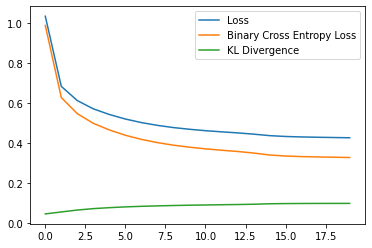

In [19]:
# produce plot ...

import matplotlib.pyplot as plt
plt.plot(cache_train['loss'])
plt.plot(cache_train['bce'])
plt.plot(cache_train['kld'])
plt.legend(['Loss', 'Binary Cross Entropy Loss', 'KL Divergence'])

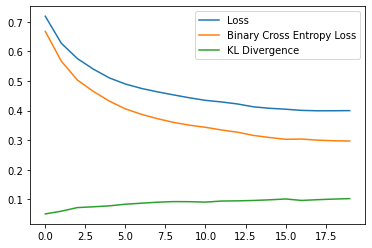

In [20]:
plt.plot(cache_valid['loss'])
plt.plot(cache_valid['bce'])
plt.plot(cache_valid['kld'])
plt.legend(['Loss', 'Binary Cross Entropy Loss', 'KL Divergence'])

In [21]:
model.load_state_dict(torch.load('model.pt')['state_dict'])
model.cuda()

VAE(
  (encoder): Encoder(
    (convolution_1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (activation_1): ReLU()
    (convolution_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (activation_2): ReLU()
    (convolution_3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (activation_3): ReLU()
    (flat): Flatten(start_dim=1, end_dim=-1)
    (mu): Linear(in_features=3200, out_features=20, bias=True)
    (logvar): Linear(in_features=3200, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (linear): Linear(in_features=20, out_features=3200, bias=True)
    (transpose_1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(4, 4), output_padding=(1, 1))
    (activation_1): ReLU()
    (transpose_2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(5, 5), output_padding=(1, 1))
    (activation_2): ReLU()
    (transpose_3): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(9, 9), output_padding=(1, 1))
    (activat

### Evaluation
- **We provide the code below for sampling, interpolation, and marginal likelihood estimation**
- Sampling and interpolation: achieve similar to the lab (this is subjective, so the purpose is to check if something is *way off*)
- Marginal likelihood: achieve better than the lab



*Please ensure that `model` contains the model state that you will use for evaluation before running these.*

#### Sampling

*no code modification needed*

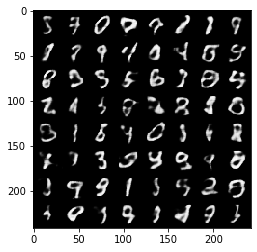

In [22]:
from torchvision.utils import make_grid

N = 64
model.eval()

# Sample z~p(z)
z = torch.randn((N, model.encoder.zdim)).to(device)

# Decode
sample = model.decoder(z)

# Visualize
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

imgs = sample
grid = make_grid(imgs).detach().cpu()
show(grid)

#### Interpolation

*no code modification needed*

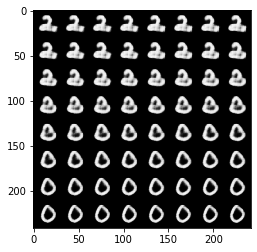

In [23]:
model.eval()

x, y = next(train_loader.__iter__())
xhat, mu, logvar = model(x.cuda())
si, ei = np.random.choice(batch_size, size=2, replace=False)
start = mu[si]
end = mu[ei]

N = 64

zs = torch.zeros(N, model.encoder.zdim).to(device)
for i in range(N):
    zs[i] = i / (N) * start.data + (1 - i / (N) ) * end.data
xhat = model.decoder(zs)

imgs = xhat.unsqueeze(0).unsqueeze(0).view(N, 1, 28, 28)
grid = make_grid(imgs).detach().cpu()
show(grid)

#### Marginal likelihood

*no code modification needed*

In [24]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

eval_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=1, shuffle=True)

N_samples = 128

model.eval()
results = []
with torch.no_grad():
  for i, (x, y) in tqdm_notebook(enumerate(eval_loader), total=len(eval_loader)):
    x, y = next(eval_loader.__iter__())
    x = x.to(device).expand(N_samples, 1, 28, 28)

    # Obtain mu, logvar and sample z
    _, mu, logvar = model(x)
    z = mu + logvar.mul(0.5).exp()*torch.randn_like(mu)

    # Obtain xhat given the sampled z
    xhat = model.decoder(z)

    # Make a standard normal for p(z) and a normal for q(z|x)
    norm = MultivariateNormal(
        torch.zeros_like(mu[0]), 
        covariance_matrix=torch.diag(torch.ones_like(logvar[0]))
    )
    mvn = MultivariateNormal(
        mu[0], 
        covariance_matrix=torch.diag(logvar.exp()[0])
    )

    # Measure the (log) probabilities needed for the formula above
    log_pz = norm.log_prob(z)
    log_qzx = mvn.log_prob(z)
    x = x.view(xhat.size())
    log_pxz = -nn.functional.binary_cross_entropy(
        xhat, x, reduction='none'
    ).view(N_samples, -1).sum(1)

    # Compute the lowerbound (in log space)
    argsum = log_pxz + log_pz - log_qzx
    logpx = -np.log(N_samples) + torch.logsumexp(argsum, 0)
    results.append(logpx.item())

np.mean(results)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


-103.86766206436157



---

# 2. Conditional variational autoencoder (20 points)

### A. Model

The conditional VAE involves:
- $q_{\phi}(\mathbf{z}|\mathbf{x},c)$: "encoder"
- $p_{\theta}(\mathbf{x}|\mathbf{z},c)$: "decoder"
- $p(\mathbf{z})$: prior

In our case, $c\in \{0,...,9\}$ is a discrete variable (class label).

**Your task:** Implement a `CVAE` that has an `encoder`, `decoder`, and `reparameterization`.

*Hints*: 
  1. Represent $c$ using a `nn.Embedding` layer, and concatenate it to the representation of $\mathbf{x}$.
    - e.g. $\mu = \texttt{linear([conv(x); emb(c)])}$
  2. Represent `decoder` inputs $\mathbf{z},c$ similarly, as $[\mathbf{z};\text{emb}(c)]$.
    - $\hat{x}=\texttt{deconv(linear([z; emb(c)]))}$

Otherwise, everything else is the same as VAE (plus passing $c$ as an argument in the right places). You can use the same convolutional layers as above.

In [25]:
class Encoder(nn.Module):
  def __init__(self, zdim, nclasses):
    super().__init__()
    # TODO
    self.zdim = zdim

    self.convolution_1 = nn.Conv2d(in_channels= 1, out_channels= 8, kernel_size= 3, stride= 1, padding=0)
    self.activation_1 = nn.ReLU()

    self.convolution_2 = nn.Conv2d(in_channels= 8, out_channels= 16, kernel_size= 3, stride= 2, padding=0)
    self.activation_2 = nn.ReLU()

    self.convolution_3 = nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size= 3, stride= 1, padding= 0)
    self.activation_3 = nn.ReLU()

    self.flatten = nn.Flatten()
    self.embed = nn.Embedding(num_embeddings= nclasses, embedding_dim= zdim)

    self.linear1 = nn.Linear(in_features= 3200, out_features= zdim)

    self.mu = nn.Linear(in_features= 2 * zdim, out_features= zdim)
    self.logvar = nn.Linear(in_features= 2 * zdim, out_features= zdim)

  def forward(self, x, c):
    # TODO
    x = self.convolution_1(x)
    x = self.activation_1(x)
    
    x = self.convolution_2(x)
    x = self.activation_2(x)

    x = self.convolution_3(x)
    x = self.activation_3(x)

    x = self.flatten(x)
    x = self.linear1(x)
    
    c = self.embed(c)
    
    h = torch.cat((x, c), 1)
    
    mu = self.mu(h)
    logvar = self.logvar(h)
    return mu, logvar


class Decoder(nn.Module):
  def __init__(self, zdim, nclasses):
    super().__init__()
    # TODO
    self.embed = nn.Embedding(num_embeddings= nclasses, embedding_dim= zdim)

    self.linear1 = nn.Linear(in_features= 2 * zdim, out_features= 3200)

    self.transpose1 = nn.ConvTranspose2d(in_channels= 32, out_channels= 16, kernel_size= 3, stride= 2, padding= 1, output_padding= 1)
    self.act1 = nn.ReLU()

    self.transpose2 = nn.ConvTranspose2d(in_channels= 16, out_channels= 1, kernel_size= 3, stride= 2, padding= 7, output_padding= 1)
    self.act2 = nn.Sigmoid()

    self.zdim = zdim
  
  def forward(self, z, c):
    # TODO
    c = self.embed(c)

    z = torch.cat((z, c), 1)

    z = self.linear1(z)
    z = z.reshape([-1, 32, 10, 10])

    z = self.transpose1(z)
    z = self.act1(z)

    z = self.transpose2(z)
    out = self.act2(z)
    return out


class CVAE(nn.Module):
  def __init__(self, zdim, nclasses):
    super().__init__()
    # TODO
    self.encoder= Encoder(zdim, nclasses)
    self.decoder= Decoder(zdim, nclasses)

    self.zdim = zdim

  def reparameterize(self, mu, logvar):
    # TODO
    if self.training:
      std = torch.exp(0.5*logvar)
      eps = torch.randn_like(std)
      z = mu + std*eps
    else:
      z = mu
    return z
 
  def forward(self, x, c):
    # TODO
    mu, logvar = self.encoder(x, c)
    z = self.reparameterize(mu, logvar)
    xhat = self.decoder(z, c)
    return xhat, mu, logvar

**Loss:** same as VAE.

In [26]:
def loss_function(xhat, x, mu, logvar, kl_weight=1.0):
  BCE = nn.functional.binary_cross_entropy(
      xhat.view(xhat.size(0), -1), x.view(x.size(0), -1), reduction='none'
  ).sum(1).mean()
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1).mean()

  loss = BCE + kl_weight*KLD
  return loss, BCE.item(), KLD.item()

### C. Training

Train your conditional VAE model using your loss function on MNIST.

**Your task:** Implement training logic, and *produce a plot of training loss and a plot of validation loss* (x-axis: epoch, y-axis: loss). Each plot should contain three lines: total loss, BCE, and KL-divergence.


In [27]:
device = torch.device("cuda:0")
zdim = 20        # use this
kl_weight = 1.0  # use this

cmodel = CVAE(zdim=20, nclasses=10).to(device)

coptimizer = torch.optim.Adam(
    cmodel.parameters(),
    lr=1e-3,
)

In [28]:
from tqdm import tqdm_notebook

In [29]:
def ctrain(epoch):
  #pass
  cmodel.train()
  train_loss, bce, kld= 0.0, 0.0, 0.0
  for batch_idx, (x, y) in tqdm_notebook(enumerate(train_loader), total=len(train_loader)):
    x = x.to(device)
    y = y.to(device)
    xhat, mu, logvar = cmodel(x, y)
  
    loss, bce_, kld_ = loss_function(xhat, x, mu, logvar)
    coptimizer.zero_grad()
    loss.backward()
    coptimizer.step()

    train_loss += loss.item()
    bce += bce_
    kld += kld_


  print('====> Epoch: {} Average loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        epoch, 
        train_loss / len(train_loader.dataset),
        bce / len(train_loader.dataset),
        kld / len(train_loader.dataset)
    ))
  
  return (train_loss / len(train_loader.dataset)),(bce / len(train_loader.dataset)), (kld / len(train_loader.dataset))

def cvalid(epoch):
  #pass
  cmodel.eval()
  test_loss, bce, kld = 0.0, 0.0, 0.0
  with torch.no_grad():
    for idx, (x, y) in enumerate(test_loader):
      x = x.to(device)
      y = y.to(device)
      xhat, mu, logvar = cmodel(x, y)
      loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)

      test_loss += loss.item()
      bce += bce_
      kld += kld_
    
    test_loss /= len(test_loader.dataset)
    print('====> Valid set loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        test_loss,
        bce / len(test_loader.dataset),
        kld / len(test_loader.dataset)
    ))
    
    
    return test_loss,(bce / len(test_loader.dataset)),(kld / len(test_loader.dataset))
# train, validate ..
num_epochs = 20
best_loss = 1e5

ccache_train = dict(loss=[], bce=[], kld=[])
ccache_valid = dict(loss=[], bce=[], kld=[])

for epoch in range(num_epochs):
  loss_train, bce_train, kld_train = ctrain(epoch)
  loss_valid, bce_valid, kld_valid = cvalid(epoch)

  ccache_train['loss'].append(loss_train)
  ccache_train['bce'].append(bce_train)
  ccache_train['kld'].append(kld_train)
  
  ccache_valid['loss'].append(loss_valid)
  ccache_valid['bce'].append(bce_valid)
  ccache_valid['kld'].append(kld_valid)

  if loss_valid < best_loss:
    torch.save({
        'state_dict': cmodel.state_dict(),
        'valid_loss': ccache_valid['loss']
    }, open('cmodel.pt', 'wb'))
    best_loss = loss_valid


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



====> Epoch: 0 Average loss: 0.8166 (bce 0.7679, kld 0.0487)
====> Valid set loss: 0.5405 (bce 0.4820, kld 0.0585)



====> Epoch: 1 Average loss: 0.5219 (bce 0.4584, kld 0.0635)
====> Valid set loss: 0.4699 (bce 0.3988, kld 0.0711)



====> Epoch: 2 Average loss: 0.4784 (bce 0.4069, kld 0.0715)
====> Valid set loss: 0.4380 (bce 0.3632, kld 0.0749)



====> Epoch: 3 Average loss: 0.4555 (bce 0.3804, kld 0.0751)
====> Valid set loss: 0.4206 (bce 0.3435, kld 0.0771)



====> Epoch: 4 Average loss: 0.4397 (bce 0.3620, kld 0.0777)
====> Valid set loss: 0.4086 (bce 0.3286, kld 0.0801)



====> Epoch: 5 Average loss: 0.4286 (bce 0.3493, kld 0.0793)
====> Valid set loss: 0.3994 (bce 0.3169, kld 0.0825)



====> Epoch: 6 Average loss: 0.4203 (bce 0.3397, kld 0.0806)
====> Valid set loss: 0.3913 (bce 0.3096, kld 0.0817)



====> Epoch: 7 Average loss: 0.4145 (bce 0.3328, kld 0.0817)
====> Valid set loss: 0.3859 (bce 0.3031, kld 0.0829)



====> Epoch: 8 Average loss: 0.4105 (bce 0.3282, kld 0.0823)
====> Valid set loss: 0.3822 (bce 0.2990, kld 0.0832)



====> Epoch: 9 Average loss: 0.4074 (bce 0.3247, kld 0.0827)
====> Valid set loss: 0.3797 (bce 0.2958, kld 0.0839)



====> Epoch: 10 Average loss: 0.4047 (bce 0.3216, kld 0.0830)
====> Valid set loss: 0.3777 (bce 0.2936, kld 0.0840)



====> Epoch: 11 Average loss: 0.4023 (bce 0.3192, kld 0.0831)
====> Valid set loss: 0.3770 (bce 0.2923, kld 0.0847)



====> Epoch: 12 Average loss: 0.4006 (bce 0.3173, kld 0.0833)
====> Valid set loss: 0.3755 (bce 0.2903, kld 0.0851)



====> Epoch: 13 Average loss: 0.3991 (bce 0.3156, kld 0.0835)
====> Valid set loss: 0.3727 (bce 0.2874, kld 0.0854)



====> Epoch: 14 Average loss: 0.3974 (bce 0.3139, kld 0.0835)
====> Valid set loss: 0.3724 (bce 0.2869, kld 0.0855)



====> Epoch: 15 Average loss: 0.3963 (bce 0.3129, kld 0.0834)
====> Valid set loss: 0.3710 (bce 0.2866, kld 0.0844)



====> Epoch: 16 Average loss: 0.3951 (bce 0.3115, kld 0.0835)
====> Valid set loss: 0.3717 (bce 0.2861, kld 0.0855)



====> Epoch: 17 Average loss: 0.3941 (bce 0.3106, kld 0.0835)
====> Valid set loss: 0.3686 (bce 0.2840, kld 0.0846)



====> Epoch: 18 Average loss: 0.3932 (bce 0.3097, kld 0.0834)
====> Valid set loss: 0.3683 (bce 0.2827, kld 0.0856)



====> Epoch: 19 Average loss: 0.3924 (bce 0.3090, kld 0.0834)
====> Valid set loss: 0.3686 (bce 0.2825, kld 0.0861)


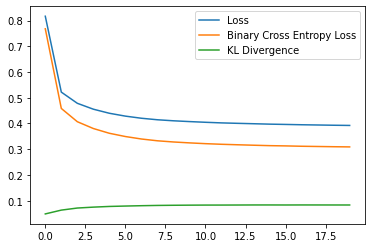

In [30]:
plt.plot(ccache_train['loss'])
plt.plot(ccache_train['bce'])
plt.plot(ccache_train['kld'])
plt.legend(['Loss', 'Binary Cross Entropy Loss', 'KL Divergence'])

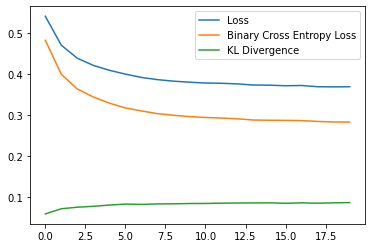

In [31]:
plt.plot(ccache_valid['loss'])
plt.plot(ccache_valid['bce'])
plt.plot(ccache_valid['kld'])
plt.legend(['Loss', 'Binary Cross Entropy Loss', 'KL Divergence'])

In [32]:
cmodel.load_state_dict(torch.load('cmodel.pt')['state_dict'])
cmodel.cuda()

CVAE(
  (encoder): Encoder(
    (convolution_1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (activation_1): ReLU()
    (convolution_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (activation_2): ReLU()
    (convolution_3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (activation_3): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (embed): Embedding(10, 20)
    (linear1): Linear(in_features=3200, out_features=20, bias=True)
    (mu): Linear(in_features=40, out_features=20, bias=True)
    (logvar): Linear(in_features=40, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (embed): Embedding(10, 20)
    (linear1): Linear(in_features=40, out_features=3200, bias=True)
    (transpose1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (act1): ReLU()
    (transpose2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(7, 7), output_padding=(1, 1))
    (act2): Sigmoid()
  )
)

### D. Conditional generation

**Your task**: complete the code below to produce a grid of samples with 10 rows, where the $i$'th row has samples of class $i$.

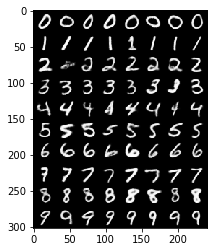

In [35]:
from torchvision.utils import make_grid
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


N = 8
model.eval()
grids = []
a = next(iter(train_loader))
for y_ in range(10):
  
  # TODO (the ... does not imply it is a single line)
  # sample = ...
  idxes = (a[1] == y_).nonzero()[:N]
  for idx in idxes:
    x = a[0][idx].to(device)
    y = torch.tensor(y_).to(device)
    y = torch.unsqueeze(y, 0)
    sample, mu, logvar = cmodel(x, y)
    grids.append(sample)
  
grid = torch.cat(grids, 0)
grid = make_grid(grid).detach().cpu()
show(grid)